In [1]:
# automatically reload edited modules
%load_ext autoreload
%autoreload 2
import tensorflow as tf
from copy import  deepcopy
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display
import os
#os.chdir('/home/yash/Documents/EWC/Elastic-Weight-Consolidation')
from model import Model
import pdb

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
sess = tf.InteractiveSession()

# define input and target placeholders
x = tf.placeholder(tf.float32, shape=[None, 43])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
task_cl_lab = tf.placeholder(tf.int32, shape=[2])

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
import pickle
f = open("UNSW.pickle", "rb")
X_train = pickle.load(f)
X_test = pickle.load(f) 
Y_train_all_attacks = pickle.load(f) 
Y_test_all_attacks = pickle.load(f) 
f.close()

print(X_train.shape, X_test.shape, Y_train_all_attacks.shape, Y_test_all_attacks.shape)

from keras.utils import np_utils

#task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9],[1,5],[7,9],[3,8],[0,6],[4,2]]
#task_labels = [[4,2], [0,6], [3,8], [9,7], [1,5],[8,9],[6,7],[5,5],[3,2],[0,1]]
task_labels = [[8,9], [6,7], [4,5], [2,3], [0,1], [1,5],[7,9]]
#task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9],[1,5],[7,9]] 
#task_labels = [[0,1], [2,3],[4,5], [6,7],[8,9]]
#task_labels = [[0,1], [2,3,1,0],[4,5,1,2], [6,7,3,0],[8,9,4,6]]
n_tasks = len(task_labels)
nb_classes  = 10
training_datasets = []
validation_datasets = []
multihead=False

for labels in task_labels:
    idx = np.in1d(Y_train_all_attacks, labels)
    if multihead:
        label_map = np.arange(nb_classes)
        label_map[labels] = np.arange(len(labels))
        data = X_train[idx], np_utils.to_categorical(label_map[Y_train_all_attacks[idx]], len(labels))
    else:
        data = X_train[idx], np_utils.to_categorical(Y_train_all_attacks[idx], nb_classes)
        training_datasets.append(data)

for labels in task_labels:
    idx = np.in1d(Y_test_all_attacks, labels)
    if multihead:
        label_map = np.arange(nb_classes)
        label_map[labels] = np.arange(len(labels))
        data = X_test[idx], np_utils.to_categorical(label_map[Y_test_all_attacks[idx]], len(labels))
    else:
        data = X_test[idx], np_utils.to_categorical(Y_test_all_attacks[idx], nb_classes)
        validation_datasets.append(data)
        
tasks_train={}; labels_train = {}; tasks_test = {}; labels_test = {}

for i in range(len(task_labels)):
    tasks_train[str(i)] = training_datasets[i][0]
    labels_train[str(i)] = training_datasets[i][1]
    tasks_test[str(i)] = validation_datasets[i][0]
    labels_test[str(i)] = validation_datasets[i][1]
    print('Task {0} size: Trainset - {1}, {2}, Testset - {3}, {4}'.format(i,tasks_train[str(i)].shape, labels_train[str(i)].shape, tasks_test[str(i)].shape, labels_test[str(i)].shape))

(82332, 43) (175341, 43) (82332,) (175341,)
Task 0 size: Trainset - (1260, 43), (1260, 10), Testset - (3746, 43), (3746, 10)
Task 1 size: Trainset - (15221, 43), (15221, 10), Testset - (45657, 43), (45657, 10)
Task 2 size: Trainset - (24933, 43), (24933, 10), Testset - (58184, 43), (58184, 10)
Task 3 size: Trainset - (40496, 43), (40496, 10), Testset - (66491, 43), (66491, 10)
Task 4 size: Trainset - (422, 43), (422, 10), Testset - (1263, 43), (1263, 10)
Task 5 size: Trainset - (6440, 43), (6440, 10), Testset - (19317, 43), (19317, 10)
Task 6 size: Trainset - (4766, 43), (4766, 10), Testset - (14264, 43), (14264, 10)


Using TensorFlow backend.


In [4]:
def mnist_imshow(img):
    plt.imshow(img.reshape([28, 28]), cmap='gray')
    plt.axis('off')

# return a new mnist dataset w/ pixels randomly permuted
def permute_mnist(mnist):
    perm_inds = list(range(mnist.train.images.shape[1]))
#     print (range(mnist.train.images.shape[1]))
    np.random.shuffle(perm_inds)
    mnist2 = deepcopy(mnist)
    sets = ["train", "validation", "test"]
    for set_name in sets:
        this_set = getattr(mnist2, set_name) # shallow copy
#         print (np.array([this_set.images[:,i] for i in [1,2,3,4]]).shape)
        #dafaq is with ._images, where did this shit come from, but okay moving on with lyf 
        this_set._images = np.transpose(np.array([this_set.images[:,c] for c in perm_inds]))
    return mnist2

def plot_test_acc(plot_handles):
    plt.legend(handles=plot_handles, loc="center right")
    plt.xlabel("Iterations")
    plt.ylabel("Test Accuracy")
    plt.ylim(0, 1.1)
    display.display(plt.gcf())
    display.clear_output(wait=True)

#manupulated the validation code: validation task by task        
def split_padded(a,n):
    padding = (-len(a))%n
    return np.split(np.concatenate((a,np.zeros(padding))),n)

def train_model(model, train_set, test_sets, num_iters=1000, disp_freq=50, lams=[0]):
    Fisher_inf_history=[]
    Linear_Fisher_history=[]
    Params = []
    Parm_grads = []
    loss_save = []
    surrogate_loss_save = []
    for l in range(len(lams)):
        '''
        if lams[l] == 0:
            model.vanilla_loss()
        else:
            model.set_ewc_loss(lams[l])
        '''
        model.vanilla_loss()
        
        test_accs = []
        for i in range(len(tasks_test)):
            test_accs.append(np.zeros(int(num_iters / disp_freq)))
        
        save_accs = {}
        for continual_task in range(len(task_labels)):
            for task in range(len(tasks_test)):
                save_accs[str(continual_task)+str(task)] = []
            
        colors = ['r', 'b', 'g', 'c', 'm', 'y','k']
        for continual_task in range(len(task_labels)):
            model.restore(sess)
            #train_batch = train_set.train.next_batch(100)
            #feed_dict = {x: train_batch[0], y_: train_batch[1]}  
            sample_inds = np.arange(len(tasks_train[str(continual_task)]))
            #batch_ids = split_padded(sample_inds,num_iters)  #Equal sized minibatches run for 1 iteration.
            batch_ids = [sample_inds] * num_iters #All samples fed and run for num_iters iterations.
            for it in range(num_iters-1):
                x_minibatches = tasks_train[str(continual_task)][batch_ids[it].astype(int),:]
                y_minibatches = labels_train[str(continual_task)][batch_ids[it].astype(int),:]
                feed_dict={x:x_minibatches, y_:y_minibatches, task_cl_lab:task_labels[continual_task]}
                model.train_step.run(feed_dict=feed_dict)
                            
                if it%disp_freq == 0:
                    plt.subplot(1, len(task_labels), continual_task+1)
                    plots = []

                    for task in range(len(tasks_test)):
                        index = int(it/disp_freq)
                        #feed_dict = {x: test_sets[task].test.images, y_:test_sets[task].test.labels}
                        feed_dict = {x:tasks_test[str(task)], y_:labels_test[str(task)], task_cl_lab:task_labels[task]}
                        computed_acc = model.accuracy.eval(feed_dict=feed_dict)
                        test_accs[task][index] = computed_acc
                        save_accs[str(continual_task)+str(task)].append(computed_acc)
                        task_char = chr(ord('A') +task)
                        plot_h, = plt.plot(range(1, it+2, disp_freq), test_accs[task][:index+1], colors[task], label = "Task" + task_char)
                        plots.append(plot_h)
                        
                    plot_test_acc(plots)

                    if lams[l] == 0:
                        plt.title("Vanilla SGD")
                    else:
                        task_countr = chr(ord('A')+continual_task)
                        plt.title("EWC: Task-"+task_countr)

                    plt.gcf().set_size_inches(15, 3.5)
                    plt.subplots_adjust(wspace = 0.4)
                    if test_accs[continual_task][index] > 0.95: #Prevent model from overfitting. if accuracy is more than 90%, no need to further train.
                        break
            
            model.task = task_labels[continual_task]
            loss_save.append(model.cross_entropy.eval(feed_dict={x:x_minibatches, y_:y_minibatches, task_cl_lab:task_labels[continual_task]}))
            parm_grads = sess.run(model.parm_grads, feed_dict={x: tasks_train[str(continual_task)], y_:labels_train[str(continual_task)], task_cl_lab:task_labels[continual_task]})
            Parm_grads.append(parm_grads)
            if lams[l] != 0:
                fisher_inf,linear_fisher,params = model.compute_fisher(tasks_test[str(continual_task)], sess, num_samples=100, plot_diffs=False)                
                Fisher_inf_history.append(fisher_inf)
                Linear_Fisher_history.append(linear_fisher)
                Params.append(params)
                #if continual_task == 0:
                model.star()
                model.set_ewc_loss(lams[l])
                model.task = task_labels[continual_task]
                surrogate_loss_save.append(model.ewc_loss.eval(feed_dict={x:x_minibatches, y_:y_minibatches, task_cl_lab:task_labels[continual_task]}))
    surrogate_loss_save[0] = 0
    return(Fisher_inf_history, Linear_Fisher_history,Params,Parm_grads,save_accs,loss_save,surrogate_loss_save)

In [5]:
# instantiate new model
model = Model(x, y_,task_cl_lab) # simple 2-layer network
sess.run(tf.global_variables_initializer())

Instructions for updating:
Colocations handled automatically by placer.


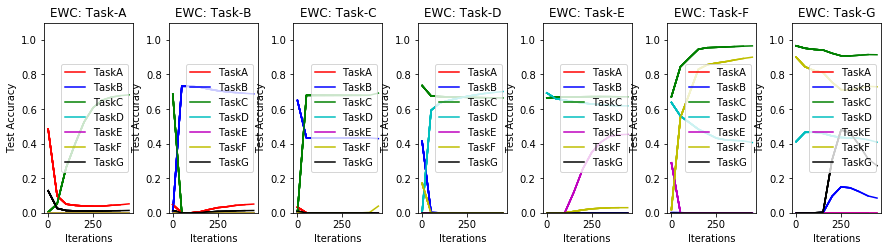

In [6]:
mnist2 = permute_mnist(mnist) # get second mnist
Fisher_inf_history,Linear_Fisher_history,Params,Parm_grads,save_accs,loss_after_task,surrogate_loss_after_task = train_model(model, mnist2, [mnist, mnist2], 500, 50, [20]) # train on task-B 

[[7.50000000e-01 0.00000000e+00 6.82129085e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.36006726e-02]
 [5.04538156e-02 6.87342584e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.32501405e-02]
 [0.00000000e+00 4.28740382e-01 6.92011535e-01 0.00000000e+00
  0.00000000e+00 3.88259031e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 6.64065719e-01 7.01147497e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.62829359e-04 6.70338929e-01 6.18068635e-01
  4.53681707e-01 2.96629909e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.65007544e-01 4.06190306e-01
  0.00000000e+00 8.99777412e-01 0.00000000e+00]
 [0.00000000e+00 8.50910023e-02 9.13721979e-01 4.08145458e-01
  0.00000000e+00 7.28529274e-01 2.72363991e-01]]
Average accuracy =  [0.75, 0.36889819987118244, 0.37358397245407104, 0.3413033038377762, 0.3484704201808199, 0.37849587698777515, 0.3439788147807121]


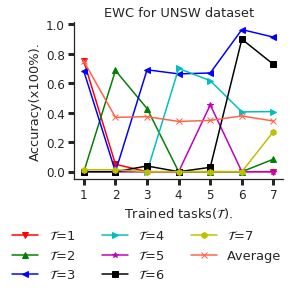

In [7]:
from matplotlib import *
import sys
from pylab import *
import matplotlib.colors as colors
import matplotlib.cm as cmx
import seaborn as sns
sns.set_style("ticks")

plot_array=np.zeros((len(tasks_test),len(tasks_test)))
for continual_task in range(len(task_labels)):
    for task in range(len(tasks_test)):
        plot_array[continual_task][task] = save_accs[str(continual_task)+str(task)][-1]
plot_array[0][0]=0.75        
print(plot_array)

figure(figsize=(4, 4.5))
axs = [subplot(1,1,1)]#, None, None]
fontsize = 13

colorVal = ['r','g','b','c','m','k','y','tomato']
marker=["v","^","<",">","*","s","h","x","."]

mean_stuff=[]
for i in range(len(plot_array)):
    mean_stuff.append(plot_array[i][:i+1].mean())
    
print('Average accuracy = ', mean_stuff)
for j in range(len(tasks_test)):
    label = "$\mathcal{T}$=%g"%(j+1)
    axs[0].plot(range(1,len(tasks_test)+1), plot_array[:, j], marker=marker[j], c=colorVal[j], label=label)
axs[0].plot(range(1,len(tasks_test)+1), mean_stuff, marker=marker[j+1], c=colorVal[j+1], label='Average')
axs[0].legend(loc='upper right',prop={'size': fontsize}, bbox_to_anchor=(1.05, -0.25), ncol=3)
axs[0].set_xlabel("Trained tasks($\mathcal{T}$).",fontsize=fontsize)
axs[0].set_ylabel('Accuracy(x100%).',fontsize=fontsize)
axs[0].set_xticks(range(1,len(tasks_test)+1))
axs[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axs[0].tick_params(labelsize='large', width=3)
axs[0].set_title('EWC for UNSW dataset', fontsize=fontsize)

gcf().tight_layout()
sns.despine()
plt.savefig('UNSW_EWC.pdf')

In [8]:
#Inspection of behavior of importance parameter Fisher after every task 
print('Fisher (parameter importance value) profile change')
from numpy import count_nonzero
old_diag_fisher_list = [0] * len(Linear_Fisher_history[0])
def flat_list(fisher_inf):
    def flatten(x):
        try:
            it = iter(x)
        except TypeError:
            yield x
        else:
            for i in it:
                for j in flatten(i):
                    yield j

    diag_fisher_list = []               
    for i in range(len(fisher_inf)):
        diag_fisher_list.append(list(flatten(fisher_inf[i]))) 
    diag_fisher_list = list(flatten(diag_fisher_list))
    return diag_fisher_list

non_zero_imp_param = [] 
for j in range(len(Fisher_inf_history)):
    diag_fisher_list = flat_list(Fisher_inf_history[j])
    non_zero_count = count_nonzero(diag_fisher_list)
    non_zero_imp_param.append(non_zero_count)
    print('Task {0}. # of non-zero diagonal elements = {1}. Total diagonal elements = {2}'.format(j,non_zero_count, len(diag_fisher_list)))

Fisher (parameter importance value) profile change
Task 0. # of non-zero diagonal elements = 1875. Total diagonal elements = 2332
Task 1. # of non-zero diagonal elements = 2126. Total diagonal elements = 2332
Task 2. # of non-zero diagonal elements = 1923. Total diagonal elements = 2332
Task 3. # of non-zero diagonal elements = 2169. Total diagonal elements = 2332
Task 4. # of non-zero diagonal elements = 2041. Total diagonal elements = 2332
Task 5. # of non-zero diagonal elements = 2095. Total diagonal elements = 2332
Task 6. # of non-zero diagonal elements = 2112. Total diagonal elements = 2332


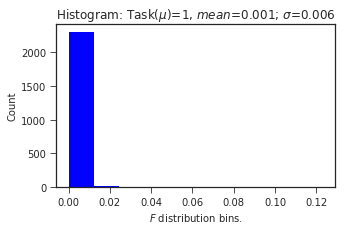

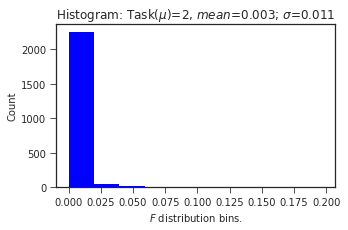

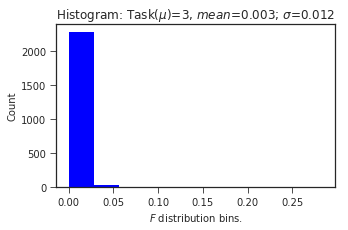

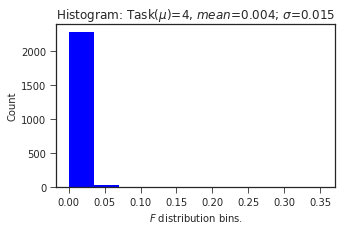

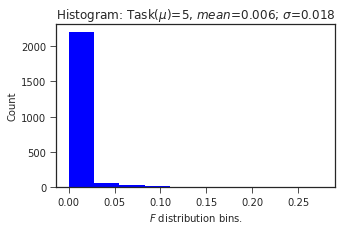

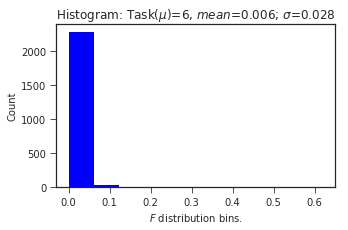

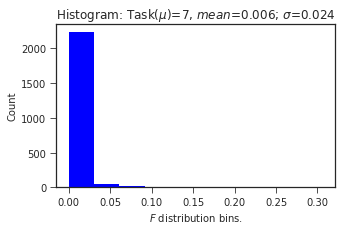

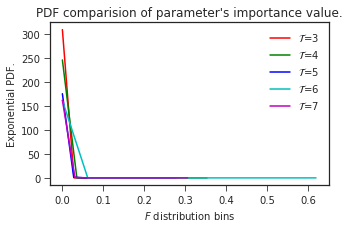

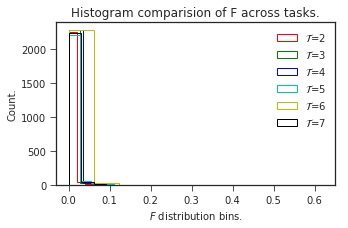

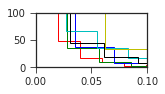

In [16]:
# histogram plot
from numpy.random import seed
from numpy.random import randn
#%matplotlib inline
from matplotlib import pyplot as plt
import itertools
import pdb

def flatten(x):
    try:
        it = iter(x)
    except TypeError:
        yield x
    else:
        for i in it:
            for j in flatten(i):
                yield j
                
per_task_fishser_dump = []
for i in range(len(Fisher_inf_history)):
    per_task_fishser_dump.append(list(flatten(Fisher_inf_history[i])))
    
pdf_save = []
bins_edge_save = []
import scipy
for i in range(len(per_task_fishser_dump)):
    plt.figure(figsize=(5,3))
    ax = subplot(1,1,1)
    _, bins, _ = ax.hist(per_task_fishser_dump[i], 10, density=0, color='blue')
    mu, sigma = scipy.stats.expon.fit(per_task_fishser_dump[i])
    best_fit_line = scipy.stats.expon.pdf(bins, mu, sigma)
    ax.set_ylabel('Count')
    ax.set_xlabel('$F$ distribution bins.')
    #ax.yaxis.label.set_color('blue')
    #second_ax = ax.twinx()
    #second_ax.plot(bins, best_fit_line, color='red')
    pdf_save.append(best_fit_line)
    bins_edge_save.append(bins)
    #second_ax.set_ylabel('Exponential PDF.', color='red')
    ax.set_title('Histogram: Task($\mu$)='+str(i+1)+ ', $mean$='+str(round(np.mean(per_task_fishser_dump[i]),3))+'; $\sigma$='+str(round(np.std(per_task_fishser_dump[i]),3)))
    if i==4 :
        plt.savefig('EWCF_dist_UNSW.pdf', bbox_inches = "tight") 
        import pickle
        with open('UNSW_T5_EWC_Omega.pkl', 'wb') as f:
            pickle.dump(per_task_fishser_dump[i], f)
plt.figure(figsize=(5,3))
axs = subplot(1,1,1)
colorVal = ['r','g','b','c','m','k','y','tomato']
marker=["v","^","<",">","*","s","h","x","."]

for j,i in enumerate(range(2,len(per_task_fishser_dump))):  
    axs.plot(bins_edge_save[i], pdf_save[i], color=colorVal[j], label="$\mathcal{T}$=%g"%(i+1))
axs.set_ylabel('Exponential PDF.')
axs.set_xlabel('$F$ distribution bins')
axs.set_title("PDF comparision of parameter\'s importance value.")
axs.legend()

plt.figure(figsize=(5,3))
axs = subplot(1,1,1)
colorVal = ['r','g','b','c','y','k','m','tomato']
marker=["v","^","<",">","*","s","h","x","."]
for j,i in enumerate(range(1,len(per_task_fishser_dump))):  
    _, bins, _ = axs.hist(per_task_fishser_dump[i], bins=10, density=0, color=colorVal[j], linewidth=1, histtype=u'step', label="$\mathcal{T}$=%g"%(i+1))
axs.set_ylabel('Count.')
axs.set_xlabel('$F$ distribution bins.')
axs.set_title("Histogram comparision of F across tasks.")
axs.legend()
plt.savefig('EWCHist_comparision_UNSW.pdf', bbox_inches = "tight") 

plt.figure(figsize=(2,1))
axs = subplot(1,1,1)
colorVal = ['r','g','b','c','y','k','m','tomato']
marker=["v","^","<",">","*","s","h","x","."]
for j,i in enumerate(range(1,len(per_task_fishser_dump))):  
    _, bins, _ = axs.hist(per_task_fishser_dump[i], bins=10, density=0, color=colorVal[j], linewidth=1, histtype=u'step', label="$\mathcal{T}$=%g"%(i+1))
axs.set_ylim(0,100)
axs.set_xlim(0,0.1)
axs.set_xticks([0, 0.05, 0.1])
axs.set_yticks([0, 50, 100])
plt.savefig('EWCHist_comparision_Zoom_UNSW.pdf', bbox_inches = "tight") 

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


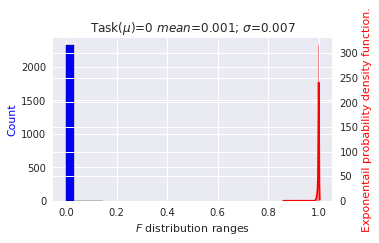

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


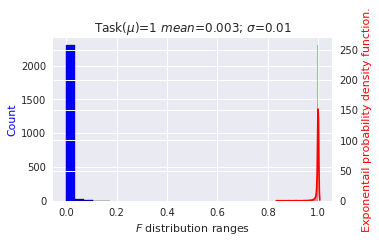

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


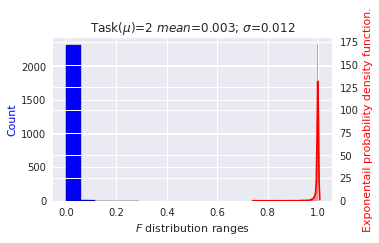

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


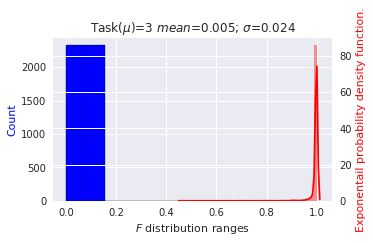

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


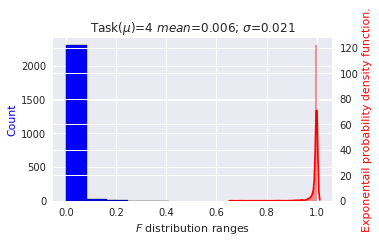

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


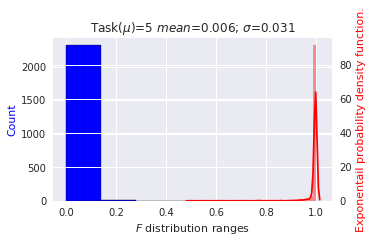

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


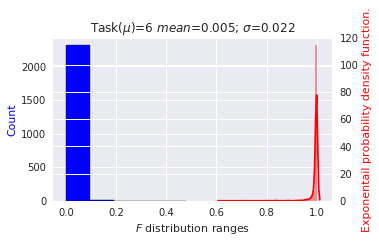

In [10]:
# histogram plot
from numpy.random import seed
from numpy.random import randn
#%matplotlib inline
from matplotlib import pyplot
import itertools
import pdb
import seaborn as sns
sns.set(color_codes=True)

def flatten(x):
    try:
        it = iter(x)
    except TypeError:
        yield x
    else:
        for i in it:
            for j in flatten(i):
                yield j
                
per_task_fishser_dump = []
for i in range(len(Fisher_inf_history)):
    per_task_fishser_dump.append(list(flatten(Fisher_inf_history[i])))

for i in range(len(per_task_fishser_dump)):
    pyplot.figure(figsize=(5,3))
    pyplot.hist(per_task_fishser_dump[i], color = 'blue', edgecolor = 'black', bins=5)
    ax = sns.distplot(per_task_fishser_dump[i], bins=10, kde=False, color='blue', hist_kws={'edgecolor':'black'})
    ax.set_ylabel('Count')
    ax.set_xlabel('$F$ distribution ranges')
    ax.yaxis.label.set_color('blue')
    second_ax = ax.twinx()
    try:  #for first task the big_omega is always 0.
        from scipy.stats import expon
        sns.distplot(expon.pdf(per_task_fishser_dump[i]), ax=second_ax, color='red')
        second_ax.set_ylabel('Exponentail probability density function.')
        #sns.distplot(per_task_fishser_dump[i], ax=second_ax, kde=True, hist=False, color='red')
        #second_ax.set_ylabel('KDE')
        second_ax.yaxis.label.set_color('red')
    except:
        pass
    pyplot.title('Task($\mu$)='+str(i)+ ' $mean$='+str(round(np.mean(per_task_fishser_dump[i]),3))+'; $\sigma$='+str(round(np.std(per_task_fishser_dump[i]),3)))
    #pyplot.savefig('ImportanceValue_w1_unsw'+str(i)+'.pdf',bbox_inches='tight')
    pyplot.show()

In [15]:
for i in range(len(Parm_grads)):
    print('For task:{0}'.format(i))
    pars = flat_list(Parm_grads[i]) 
    print('Gradients. Mean = {0}. Standard deviation = {1}. Length = {2}'.format(round(np.mean(pars),6),round(np.std(pars),6),len(pars)))
    print('---------------------------')

For task:0
Gradients. Mean = 36.0611572265625. Standard deviation = 131.04530334472656. Length = 2332
---------------------------
For task:1
Gradients. Mean = 741.8267822265625. Standard deviation = 2280.879638671875. Length = 2332
---------------------------
For task:2
Gradients. Mean = 1512.591064453125. Standard deviation = 4346.42578125. Length = 2332
---------------------------
For task:3
Gradients. Mean = 2918.126953125. Standard deviation = 7701.3681640625. Length = 2332
---------------------------
For task:4
Gradients. Mean = 29.906471252441406. Standard deviation = 78.52252960205078. Length = 2332
---------------------------
For task:5
Gradients. Mean = 587.1298217773438. Standard deviation = 1588.63671875. Length = 2332
---------------------------
For task:6
Gradients. Mean = 402.66705322265625. Standard deviation = 979.0615844726562. Length = 2332
---------------------------


In [16]:
for i in range(len(Params)):
    print('For task:{0}'.format(i))
    pars = flat_list(Params[i]) 
    print('Parameters. Mean = {0}. Standard deviation = {1}. Length = {2}'.format(round(np.mean(pars),6),round(np.std(pars),6),len(pars)))
    print('---------------------------')

For task:0
Parameters. Mean = 0.0027280000504106283. Standard deviation = 0.08789300173521042. Length = 2332
---------------------------
For task:1
Parameters. Mean = 0.007375000044703484. Standard deviation = 0.09354200214147568. Length = 2332
---------------------------
For task:2
Parameters. Mean = 0.013566999696195126. Standard deviation = 0.10856399685144424. Length = 2332
---------------------------
For task:3
Parameters. Mean = 0.020251000300049782. Standard deviation = 0.11358100175857544. Length = 2332
---------------------------
For task:4
Parameters. Mean = 0.019672999158501625. Standard deviation = 0.12073200196027756. Length = 2332
---------------------------
For task:5
Parameters. Mean = 0.02431900054216385. Standard deviation = 0.12353000044822693. Length = 2332
---------------------------
For task:6
Parameters. Mean = 0.025635000318288803. Standard deviation = 0.1273529976606369. Length = 2332
---------------------------


In [17]:
#Inspection of losses after every task 
for i,loss in enumerate(loss_after_task):
    print('Loss after task {0} is {1}'.format(i,loss_after_task[i])) 
print('*----------------------------*')

#Inspection of surrogate loss or regularization (sum(Fisher x (theta'-theta))) after every task 
for i,loss in enumerate(surrogate_loss_after_task):
    print('Surrogate loss after task {0} is {1}'.format(i,surrogate_loss_after_task[i])) 
print('*----------------------------*')

Loss after task 0 is 0.6854615211486816
Loss after task 1 is 0.5005994439125061
Loss after task 2 is 0.2914985120296478
Loss after task 3 is 0.25923433899879456
Loss after task 4 is 0.2904896140098572
Loss after task 5 is 0.27531471848487854
Loss after task 6 is 0.3634006381034851
*----------------------------*
Surrogate loss after task 0 is 0
Surrogate loss after task 1 is 0.5184646844863892
Surrogate loss after task 2 is 0.3523307740688324
Surrogate loss after task 3 is 0.3358851373195648
Surrogate loss after task 4 is 0.4215039610862732
Surrogate loss after task 5 is 0.5470929145812988
Surrogate loss after task 6 is 0.5467932224273682
*----------------------------*


In [18]:
#Creating the Hessian matrix from the gradients
import math
Hessian_matrix = []
Hessian_row = []
per_task_Hessian = []
for k in range(len(Parm_grads)):
    curr_task_grads = flat_list(Parm_grads[k])
    print('Calculating Hessian matrix for task:',k)
    for i in range(len(curr_task_grads)):
        partial_deriv_1 = (math.ceil(curr_task_grads[i]*1e10)/1e10)
        for j in range(len(curr_task_grads)):
            partial_deriv_2 = (math.ceil(curr_task_grads[j]*1e10)/1e10)
            Hessian_row.append(np.around(partial_deriv_1*partial_deriv_2))
        Hessian_matrix.append(Hessian_row)
        Hessian_row = []
           
    per_task_Hessian.append(np.asarray(Hessian_matrix))
    
#Calculating rank by counting non-zero diagonal elements
Rank_Hessian_matrix=[]
for i in range(len(per_task_Hessian)):
    rank_Hessian_matrix = np.linalg.matrix_rank(per_task_Hessian[i])
    Rank_Hessian_matrix.append(rank_Hessian_matrix)
    print('Rank of the Hessian Matrix after task=',k,'is :',rank_Hessian_matrix)

Calculating Hessian matrix for task: 0
Calculating Hessian matrix for task: 1
Calculating Hessian matrix for task: 2
Calculating Hessian matrix for task: 3
Calculating Hessian matrix for task: 4
Calculating Hessian matrix for task: 5
Calculating Hessian matrix for task: 6
Rank of the Hessian Matrix after task= 6 is : 1437
Rank of the Hessian Matrix after task= 6 is : 1834
Rank of the Hessian Matrix after task= 6 is : 1842
Rank of the Hessian Matrix after task= 6 is : 1946
Rank of the Hessian Matrix after task= 6 is : 1947
Rank of the Hessian Matrix after task= 6 is : 1947
Rank of the Hessian Matrix after task= 6 is : 1950


/usr/local/lib/python3.5/dist-packages/matplotlib/tight_layout.py:330: UserWarning: tight_layout not applied: number of rows in subplot specifications mustbe multiples of one another.
  warnings.warn('tight_layout not applied: '


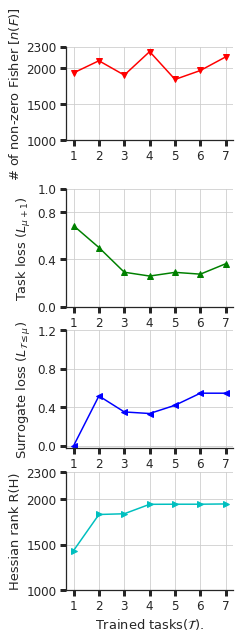

In [19]:
import pdb
figure(figsize=(3, 10))
axs = [subplot(5,1,1)]#, None, None]
for i in range(1, 4):
    axs.append(subplot(4, 1, i+1, sharex=axs[0]))
fontsize = 13

colorVal = ['r','g','b','c','m','k','y']
marker=["v","^","<",">","*","s"]

plots = [non_zero_imp_param,loss_after_task,surrogate_loss_after_task,Rank_Hessian_matrix]
ylabel = ['# of non-zero Fisher $[n(F)]$', 'Task loss ($L_{\mu+1}$)', 'Surrogate loss ($L_{\mathcal{T} \leq \mu}$)','Hessian rank R(H)']
ytick = [[1000, 1500, 2000, 2300], [0,0.4, 0.8, 1], [0,0.4, 0.8, 1.2], [1000, 1500, 2000, 2300]]
title = ['Number of non-zero importance.', 'Loss', 'Surrogate loss', 'Hessian rank R(H)']
for i in range(4):
    axs[i].plot(range(1,n_tasks+1), plots[i], marker=marker[i], c=colorVal[i])
    axs[i].set_ylabel(ylabel[i],fontsize=fontsize)
    axs[i].set_yticks(ytick[i])
    axs[i].tick_params(labelsize='large', width=3)
    axs[i].grid()
axs[-1].set_xticks(range(1,n_tasks+1))
axs[-1].set_xlabel("Trained tasks($\mathcal{T}$).",fontsize=fontsize)
plt.tight_layout()
sns.despine()
plt.savefig('UNSW_EWC_evalcongestion.pdf',bbox_inches = "tight")

--------------Euclidean distance--------------------
Between task 0 and 1 : 1.4536767705479128
Between task 1 and 2 : 2.553487088639754
Between task 2 and 3 : 2.1076093967800724
Between task 3 and 4 : 2.1176594193352893
Between task 4 and 5 : 2.322722663148138
Between task 5 and 6 : 2.42307405772298
--------------Cosine distance--------------------
Between task 0 and 1 : 0.947
Between task 1 and 2 : 0.876
Between task 2 and 3 : 0.926
Between task 3 and 4 : 0.934
Between task 4 and 5 : 0.925
Between task 5 and 6 : 0.924
--------------Jaccard similarity--------------------
Between task 0 and 1 : 0.1052132701421801
Between task 1 and 2 : 0.08974059359663472
Between task 2 and 3 : 0.05212093862815884
Between task 3 and 4 : 0.082385704339754
Between task 4 and 5 : 0.09252752401030687
Between task 5 and 6 : 0.07046132660087216
--------------Sequence Matcher--------------------
Between task 0 and 1 : 0.19039451114922812
Between task 1 and 2 : 0.1646655231560892
Between task 2 and 3 : 0.099056

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  # This is added back by InteractiveShellApp.init_path()


Between task 4 and 5 : 0.16938250428816468
Between task 5 and 6 : 0.13164665523156088


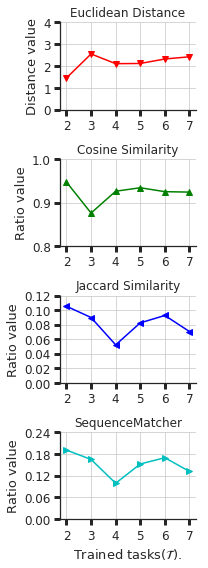

In [20]:
#Heuristic metric: Weights Pattern after training each task
from math import*
#1. Euclidean distance
def euclidean_distance(x,y):
    return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))

#2. Cosine Similarity
def square_rooted(x):
    return round(sqrt(sum([a*a for a in x])),3)
def cosine_similarity(x,y):
    numerator = sum(a*b for a,b in zip(x,y))
    denominator = square_rooted(x)*square_rooted(y)
    return round(numerator/float(denominator),3)

#3. Jaccard similarity
def jaccard_similarity(x,y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)

#4. Using SequenceMatcher    
from difflib import SequenceMatcher

Flatten_weights=[]
#Flattening the weights into a list
def flatten(x):
    try:
        it = iter(x)
    except TypeError:
        yield x
    else:
        for i in it:
            for j in flatten(i):
                yield j
model_weights_save = Params                
print("--------------Euclidean distance--------------------")
Eu_distance = []
for i in range(1,n_tasks):
    eu_dist = euclidean_distance(list(flatten(model_weights_save[i-1][-1210940:])),list(flatten(model_weights_save[i][-1210940:])))
    Eu_distance.append(eu_dist)
    print("Between task {0} and {1} : {2}".format(i-1,i,eu_dist))

print("--------------Cosine distance--------------------")
Cos_distance = []
for i in range(1,n_tasks):
    cos_dist = cosine_similarity(list(flatten(model_weights_save[i-1][-1210940:])),list(flatten(model_weights_save[i][-1210940:])))
    Cos_distance.append(cos_dist)
    print("Between task {0} and {1} : {2}".format(i-1,i,cos_dist))
    
    
print("--------------Jaccard similarity--------------------")
Jac_distance = []
for i in range(1,n_tasks):
    jac_dist = jaccard_similarity(list(flatten(model_weights_save[i-1][-1210940:])),list(flatten(model_weights_save[i][-1210940:])))
    Jac_distance.append(jac_dist)
    print("Between task {0} and {1} : {2}".format(i-1,i,jac_dist))

print("--------------Sequence Matcher--------------------")
Seq_matcher = []
for i in range(1,n_tasks):
    seq_matcher = SequenceMatcher(None,list(flatten(model_weights_save[i-1][-1210940:])),list(flatten(model_weights_save[i][-1210940:]))).ratio()
    Seq_matcher.append(seq_matcher)
    print("Between task {0} and {1} : {2}".format(i-1,i,seq_matcher))
    


import pdb
from matplotlib.pyplot import *
import seaborn as sns
figure(figsize=(3, 8))
subplots_adjust(hspace=0.25,
                    wspace=0.35)
axs = [plt.subplot(4,1,1)]#, None, None]
for i in range(1, 4):
    axs.append(subplot(4, 1, i+1, sharex=axs[0]))
fontsize = 13

colorVal = ['r','g','b','c','m','k','y']
marker=["v","^","<",">","*","s"]

plots = [Eu_distance,Cos_distance,Jac_distance,Seq_matcher]
ylabel = ['Distance value', 'Ratio value', 'Ratio value','Ratio value']
ytick = [[0, 1, 2, 3, 4], [0.8, 0.9, 1],[0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12], [0, 0.06, 0.12, 0.18, 0.24]]
title = ['Euclidean Distance', 'Cosine Similarity', 'Jaccard Similarity', 'SequenceMatcher']
for i in range(4):
    axs[i].plot(range(2,n_tasks+1), plots[i], marker=marker[i], c=colorVal[i])
    axs[i].set_ylabel(ylabel[i],fontsize=fontsize)
    axs[i].set_yticks(ytick[i])
    axs[i].tick_params(labelsize='large', width=3)
    axs[i].grid()
    axs[i].set_title(title[i])
axs[-1].set_xticks(range(2,n_tasks+1))
axs[-1].set_xlabel("Trained tasks($\mathcal{T}$).",fontsize=fontsize)
plt.tight_layout()
sns.despine()
plt.savefig('UNSW_EWC_Similaritymetric.pdf',bbox_inches = "tight")

In [21]:
#Heuristic metric: Weights Pattern between task 0 and last task 
from math import*
#1. Euclidean distance
def euclidean_distance(x,y):
    return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))

#2. Cosine Similarity
def square_rooted(x):
    return round(sqrt(sum([a*a for a in x])),3)
def cosine_similarity(x,y):
    numerator = sum(a*b for a,b in zip(x,y))
    denominator = square_rooted(x)*square_rooted(y)
    return round(numerator/float(denominator),3)

#3. Jaccard similarity
def jaccard_similarity(x,y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)

#4. Using SequenceMatcher    
from difflib import SequenceMatcher

Flatten_weights=[]
#Flattening the weights into a list
def flatten(x):
    try:
        it = iter(x)
    except TypeError:
        yield x
    else:
        for i in it:
            for j in flatten(i):
                yield j
model_weights_save = Params    
n_tasks = len(model_weights_save)


eu_dist = euclidean_distance(list(flatten(model_weights_save[0])),list(flatten(model_weights_save[-1])))
print("Euclidean distance between task {0} and {1} : {2}".format(0,len(model_weights_save)-1,eu_dist))

cos_dist = cosine_similarity(list(flatten(model_weights_save[0])),list(flatten(model_weights_save[-1])))
print("Cosine angle between task {0} and {1} : {2}".format(0,len(model_weights_save)-1,cos_dist))

jac_dist = jaccard_similarity(list(flatten(model_weights_save[0])),list(flatten(model_weights_save[-1])))
print("Jaccard similarity between task {0} and {1} : {2}".format(0,len(model_weights_save)-1,jac_dist))

seq_matcher = SequenceMatcher(None,list(flatten(model_weights_save[0])),list(flatten(model_weights_save[-1]))).ratio()
print("Sequence angle between task {0} and {1} : {2}".format(0,len(model_weights_save)-1,seq_matcher))

Euclidean distance between task 0 and 6 : 4.327980533078522
Cosine angle between task 0 and 6 : 0.726
Jaccard similarity between task 0 and 6 : 0.014354066985645933
Sequence angle between task 0 and 6 : 0.02830188679245283


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  # This is added back by InteractiveShellApp.init_path()
